# Classify handwritten digits using the famous MNIST data

> The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.  As the competition progresses, we will release tutorials which explain different machine learning algorithms and help you to get started.

> The data for this competition were taken from the MNIST dataset. The MNIST ("Modified National Institute of Standards and Technology") dataset is a classic within the Machine Learning community that has been extensively studied.  More detail about the dataset, including Machine Learning algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html.

** Dependencies **

In [17]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from time import time
import random

print("numpy", np.__version__)
print("pandas", pd.__version__)
print("seaborn", sns.__version__)

numpy 1.10.2
pandas 0.17.1
seaborn 0.6.0


## Reading the Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

In [412]:
digits = pd.read_csv("data/train.csv")

digits.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [442]:
# Extract the feature and label values
X = digits.iloc[:,1:].values
y = digits[[0]].values.ravel()

** Benchmark **

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

# Generate a 75:25 hold-out dataset
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Fit the model model
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

# Predict labels for our hold-out dataset
y_pred = clf.predict(X_test)

# Score our new model
print("Random Forest Classifier Accuracy")
clf.score(X_test, y_test)

Random Forest Classifier Accuracy


0.96380952380952378

## Visualizing the Digits

Let's take a look at some digits 

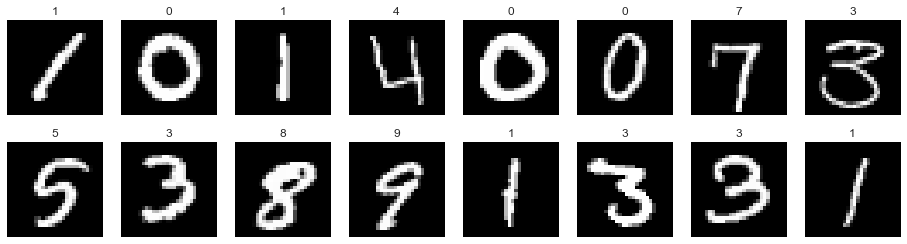

In [7]:
def plot_digits(img, labels, nrows, ncols):
    plt.figure(figsize=(min(16, ncols*2), min(16, nrows*2)))
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i+1)
        # Reshape every image to a square array 2d array
        sqrt = np.sqrt(len(img[i]))
        digit = img[i].reshape(sqrt, sqrt)
        plt.imshow(digit, interpolation='nearest', cmap=plt.cm.gray)
        plt.xticks([]); plt.yticks([])
        plt.title(labels[i])

plot_digits(X, y, 2, 8)        

### Mean Digits

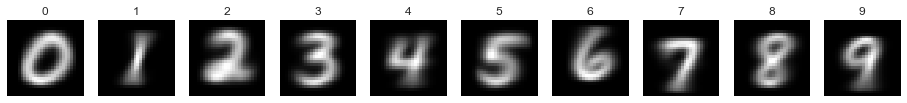

In [9]:
# Calculate average digit values
mean_digits = digits.groupby('label').mean()

# Reshape the data
mean_digit_values = mean_digits.iloc[:,0:].values

# Plot the mean digits
plot_digits(mean_digit_values, list(range(10)), 1, 10)

### Outliers

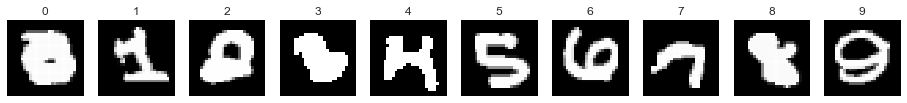

In [10]:
def find_outliers(df, mean):
    """
    Find the images with the largest diff from the mean for every label according to some distance measure
    """
    outliers = []
    for i in range(10):
        vals = df[df.label==i].iloc[:,1:].values
        # Change the following line to use some other distance measure
        dist = [np.linalg.norm(v-mean[i]) for v in vals]
        outliers.append(vals[np.argmax(dist)])
    return outliers
        
# Find an outlier for every label    
outliers = find_outliers(digits, mean_digit_values)

# Plot the outliers
plot_digits(outliers, list(range(10)), 1, 10)

### Rotating an Image

Let us write a simple function that rotates an image

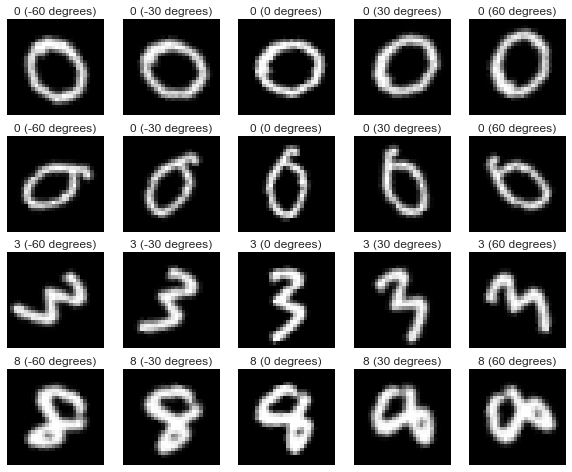

In [383]:
from scipy.ndimage.interpolation import rotate

def rotate_image(image, d):
    """
    Rotate an image d degrees
    """
    sqrt = np.sqrt(len(image))
    img = image.reshape(sqrt, sqrt)
    return rotate(img, d, reshape=False, order=1).flatten()

def rotate_images(images, y, degrees):
    """
    Rotate n images where rand determines if they are randomly selected
    from images or not
    """
    rotated_images = []; labels = []    
    for img, label in zip(images, y):
        for d in degrees:
            rotated_images.append(rotate_image(img, d))
            labels.append(str(label) + " (" + str(d) + " degrees)")
    return rotated_images, labels

# The number of digits to plot
num_digits = 4

# Degrees to rotate the images
degrees = [-60, -30, 0, 30, 60]

# Randomly select some digits to visualize
idx = random.sample(range(0, len(X)+1), num_digits)
sample_images = [X[i] for i in idx]; sampel_labels = [y[i] for i in idx]

# Rotate the selected digits
rotated_images, labels = rotate_images(sample_images, sampel_labels, degrees)

# Plot the rotated digits
plot_digits(rotated_images, labels, num_digits, len(degrees))

### Nudging the Images

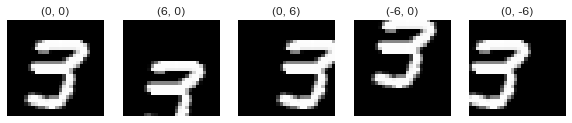

In [362]:
from scipy.ndimage.interpolation import shift

def shift_image(image, s):
    """
    Shift an image where s specifies the shift along the axes
    """
    sqrt = np.sqrt(len(image))
    img = image.reshape(sqrt, sqrt)
    return shift(img, shift=s, order=0).flatten()
  
    
translations = [(0, 0), (6, 0), (0, 6), (-6, 0), (0, -6)] 
    
shifted = [shift_image(X[2000], t) for t in translations]
                 
plot_digits(shifted, translations, 1, len(translations))

### Scaling Images

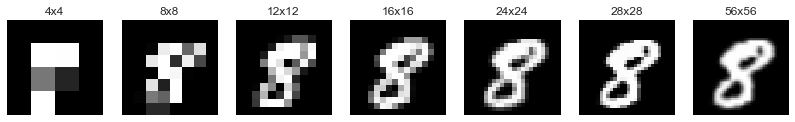

In [265]:
from skimage.transform import resize

def resize_image(image, dimension):
    """
    Resize an image to dimension x dimension
    """
    sqrt = np.sqrt(len(image))
    img = image.reshape(sqrt, sqrt).astype(np.float64)
    return resize(img, (dimension, dimension)).flatten()


# Resize dimensions
factors = [4, 8, 12, 16, 24, 28, 56]

# Labels on the form nxn
labels = [str(x) + "x" + str(x) for x in factors]

# Generate a resized image for every factor
resized_images = [resize_image(X[10], x) for x in factors]

# Plot the resized images
plot_digits(resized_images, labels, 1, len(factors))

### t-distributed stochastic neighbor embedding (t-SNE)

The t-SNE algorithm can help us effectively visualize high-dimensional data.

In [443]:
from sklearn.manifold import TSNE

NUM_SAMPLES = 5000

start = time()

# Transform our images to 2 dimensions
digits_proj = TSNE(learning_rate=600, random_state=20152612).fit_transform(X[:NUM_SAMPLES])

print("t-SNE took %.2f seconds" % (time() - start))

t-SNE took 78.74 seconds


nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan
nan nan


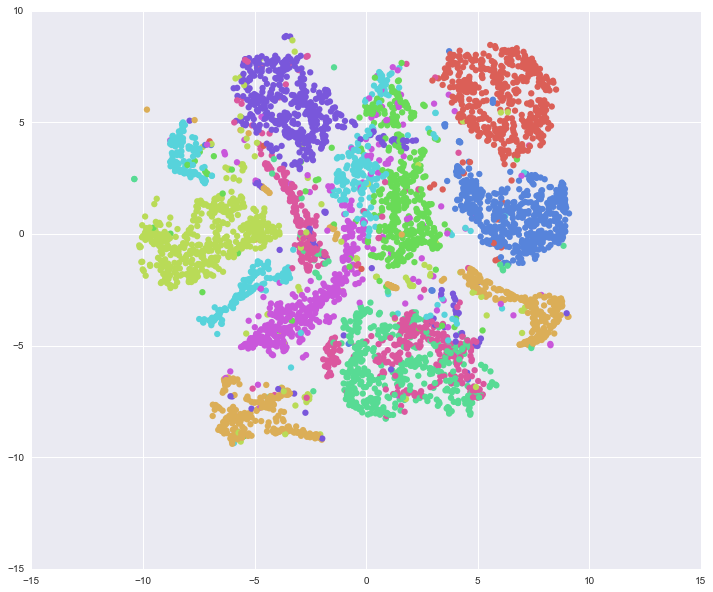

In [441]:
import matplotlib.patheffects as PathEffects

plt.figure(figsize=(12, 12))

def plot_projection(x, colors):
    """
    plot t-SNE projection of digits and label the cluster centers
    """
    palette = np.array(sns.color_palette("hls", 10))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    #TODO: Consider changing with colorbar...
    for i in range(10):
        x_text, y_text = np.median(x[np.where( colors == i )], axis=0)
    #    txt = ax.text(x_text, y_text, str(i), fontsize=20)
    #    txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
    
plot_projection(digits_proj, y[:NUM_SAMPLES])

# Convolutional Neural Network

** Dependencies **

In [425]:
import theano
import lasagne

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

print("theano", theano.__version__)
print("lasagne", lasagne.__version__)

theano 0.7.0.dev-54186290a97186b9c6b76317e007844529a352f4
lasagne 0.1


** Adding rotated digits to the training set **

In [426]:
# Degrees we rotate the additional training examples
degrees = [-15, 15]

# Generate additional training examples
rotated_images, labels = rotate_images(X, y, degrees)

# Extract the label from our label text
labels = [l.split()[0] for l in labels]

# Append the new training examples
X = np.append(X, np.array(rotated_images), axis=0)
y = np.append(y, np.array(labels), axis=0)

** Preparing Input **

In [427]:
y_train = y.astype(np.uint8)

# Normalize the color values so they are between 0 and 1
X_train = X / np.float32(X.max())

X_train = X_train.reshape((-1, 1, 28, 28))

# Generate a 75:25 hold-out dataset
# Comment out this line to use the entire training set for training
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train)

## CNN

** Initialize CNN **

In [428]:
nn = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    # None in the first axis indicates that the batch size can be set later
    input_shape=(None, 1, 28, 28),
    
    # Pool_size used to be called ds in old versions of lasagne
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    hidden4_num_units=500,
    output_num_units=10, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    
    # Number of passes over the training data
    max_epochs=10,
    # Enable printing of useful information
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

** Train CNN **

In [429]:
start = time()

# Bake our lasagne
net = nn.fit(X_train, y_train)

print("training took %.2f seconds" % (time() - start))

# Neural Network with 1166086 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input    1x28x28
  1  conv1    32x26x26
  2  pool1    32x13x13
  3  conv2    64x12x12
  4  pool2    64x6x6
  5  hidden4  500
  6  output   10

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -------
      1       0.28029       0.06991      4.00944      0.97806  245.12s
      2       0.08180       0.04766      1.71614      0.98492  243.62s
      3       0.05724       0.04020      1.42380      0.98725  245.10s
      4       0.04380       0.03384      1.29419      0.98924  245.63s
      5       0.03517       0.03030      1.16062      0.99019  246.15s
      6       0.02899       0.02951      0.98258      0.99012  244.87s
      7       0.02420       0.02879      0.84047      0.99041  244.94s
      8       0.02008       0.02979      0.67403      0.99043  243.91s
      9       0.01659       0.

** Generate Predictions **

In [411]:
from sklearn.metrics import accuracy_score

# Generate predictions for our test set
y_pred = nn.predict(X_test)

accuracy_score(y_test, y_pred)

0.98577777777777775

** Visualizing the results **

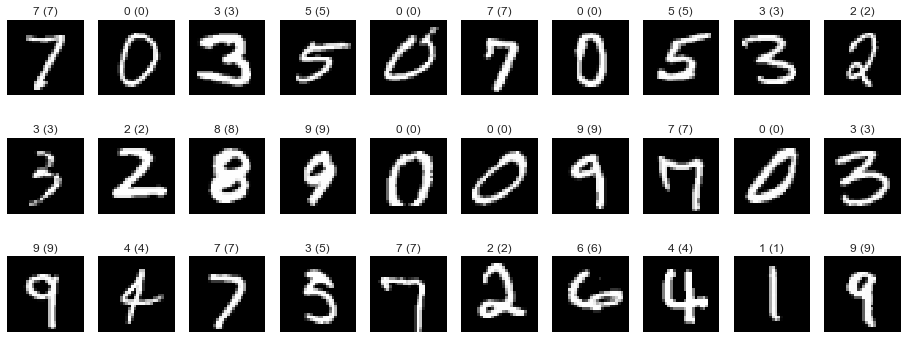

In [86]:
# Flatten our digits so they play nicely with my plot function
digits = [x.flatten() for x in X_test]; labels = []

# Generate labels with both the predicted and true value
for pred, test in zip(y_pred, y_test):
    labels.append(str(pred) + " (" + str(test) + ")")

plot_digits(digits, labels, 3, 10)

** Predicting Rotated Digits **

Just for fun, lets see how well we are able to predict the values for rotated digits.

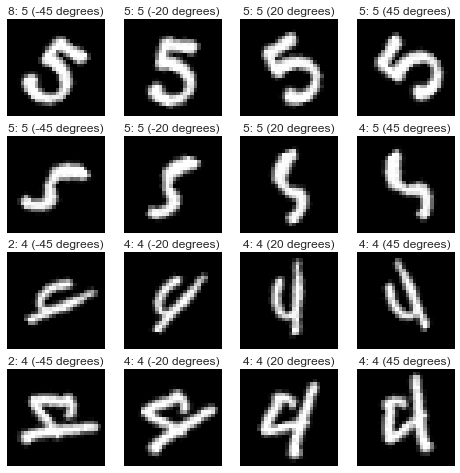

In [361]:
num_digits = 4

# Randomly select some digits to visualize
idx = random.sample(range(0, len(X)+1), num_digits)
sample_images = [X[i] for i in idx]; sampel_labels = [y[i] for i in idx]

# Degrees to rotate the images
degrees = [-45, -20, 20, 45]

# Rotate the selected digits
rotated_images, labels = rotate_images(sample_images, sampel_labels, degrees)

# Generate predictions for our rotated digits
rotated_pred = nn.predict(np.array(rotated_images).reshape((-1, 1, 28, 28)))

labels = [str(p) + ": " + str(l) for p, l in zip(rotated_pred, labels)]

# Plot our rotated digits and predictions
plot_digits(rotated_images, labels, num_digits, 4)

** Confusion Matrix **

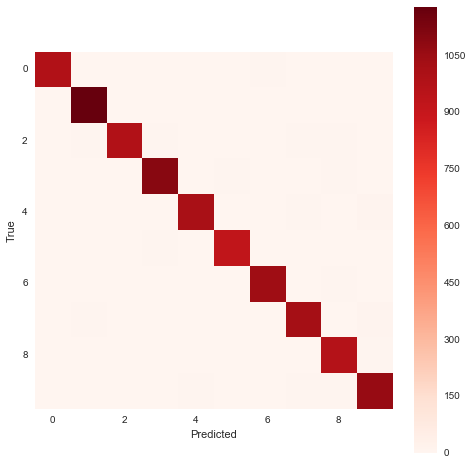

In [87]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test, predictions):
    plt.figure(figsize=(8, 8))
    cm = confusion_matrix(test, predictions)
    plt.imshow(cm, cmap='Reds', interpolation='nearest')
    plt.colorbar()
    plt.grid(False)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    
plot_confusion_matrix(y_test, y_pred)

** Filters Visualization **

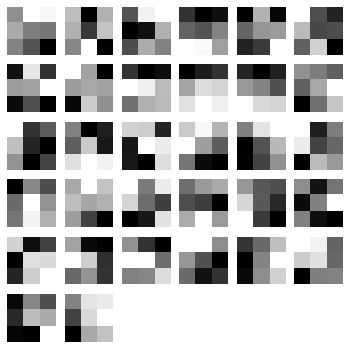

In [89]:
from nolearn.lasagne import visualize

plt.figure(figsize=(8, 8))

visualize.plot_conv_weights(nn.layers_['conv1']);

** Making a Submission File **

In [430]:
test = pd.read_csv("data/test.csv").values

# Normalize the color values so they are between 0 and 1
X_test = test / np.float32(test.max())

# Reshape the test images
X_test = X_test.reshape((-1, 1, 28, 28))

# Generate predictions
predictions = nn.predict(X_test)

# Generate image ids
idx = range(1, len(predictions) + 1)

csv = np.column_stack((idx, predictions))

np.savetxt("digits.csv", csv, delimiter=",", fmt="%d", header="ImageId,Label", comments='')